### **Semantic Segmentation using Cityscapes Data**

In [18]:
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive

COLAB_DIR = '/content/'
GT_DIR = COLAB_DIR + 'gtFine/gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg/leftImg8bit/'

import os
import glob
import pickle
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, ReLU, LeakyReLU, Add
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D

#### Importing Cityscapes Data

In [2]:
# !pip install cityscapesscripts
from cityscapesscripts.download import downloader

# registration on https://www.cityscapes-dataset.com/
session = downloader.login()
downloader.get_available_packages(session=session)

# data for semantic segmentation task
print('Downloading gtFine and leftImg8bit packages ...\n')
package_list =['gtFine_trainvaltest.zip', 'leftImg8bit_trainvaltest.zip']
downloader.download_packages(session=session, package_names=package_list, destination_path=COLAB_DIR)

In [7]:
!unzip -q gtFine_trainvaltest.zip -d gtFine
!unzip -q leftImg8bit_trainvaltest.zip -d leftImg

#### Preprocessing Data

In [8]:
# collapse child directories
for parent in listdir(GT_DIR):
    parent_dir = GT_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            keep = glob.glob(join(parent_dir, child) + '/*_gtFine_color.png')
            keep = [f.split('/')[-1] for f in keep]
            for filename in list(set(listdir(join(parent_dir, child))) & set(keep)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

for parent in listdir(IMG_DIR):
    parent_dir = IMG_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            for filename in listdir(join(parent_dir, child)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

# resize gtFine, leftImg images
IMG_SHAPE = 299, 299

gt_train_paths = [GT_DIR+'train/' + path for path in listdir(GT_DIR+'train/')]
gt_test_paths = [GT_DIR+'test/' + path for path in listdir(GT_DIR+'test/')]
gt_val_paths = [GT_DIR+'val/' + path for path in listdir(GT_DIR+'val/')]
gt_paths = gt_train_paths + gt_test_paths + gt_val_paths

im_train_paths = [IMG_DIR+'train/' + path for path in listdir(IMG_DIR+'train/')]
im_test_paths = [IMG_DIR+'test/' + path for path in listdir(IMG_DIR+'test/')]
im_val_paths = [IMG_DIR+'val/' + path for path in listdir(IMG_DIR+'val/')]
im_paths = im_train_paths + im_test_paths + im_val_paths

def resize_image(path):
    img = Image.open(path)
    img.thumbnail(IMG_SHAPE)
    out_file = join(path)
    img.save(out_file, 'PNG')

for img in gt_paths + im_paths:
    resize_image(img)

#### Archive Processed Data

In [14]:
make_archive('gtFine', 'zip', GT_DIR)
make_archive('leftImg', 'zip', IMG_DIR)

#### Load Processed Archive

In [2]:
def download_if_missing(url, target, extract=True):
    if os.path.exists(target):
        return target
    return tf.keras.utils.get_file(target, origin=url, extract=extract)

gt_url_file = 'https://storage.googleapis.com/mcg2208/gtFine.zip'
im_url_file = 'https://storage.googleapis.com/mcg2208/leftImg.zip'

gt_file, gt_dir = join(COLAB_DIR + 'gtFine.zip'), join(COLAB_DIR + 'gtFine/')
im_file, im_dir = join(COLAB_DIR + 'leftImg.zip'), join(COLAB_DIR + 'leftImg/')

download_if_missing(gt_url_file, gt_file, extract=False)
download_if_missing(im_url_file, im_file, extract=False)

!unzip -q $gt_file -d $gt_dir
!unzip -q $im_file -d $im_dir

338722816/338717519 [==============================] - 5s 0us/step


#### Transform Data

In [52]:
# normalize image pixels
IMG_SIZE = 299
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

GT_DIR = COLAB_DIR + 'gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg/'

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img /= 255.0
    return img

def get_image_paths(dir):
    return sorted([dir + path for path in listdir(dir)])

# create tf.Dataset objects
gt_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'train/'))
gt_train_ds = gt_train_ds.map(load_and_preprocess_image)

gt_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'test/'))
gt_test_ds = gt_test_ds.map(load_and_preprocess_image)

gt_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'val/'))
gt_val_ds = gt_val_ds.map(load_and_preprocess_image)

im_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'train/'))
im_train_ds = im_train_ds.map(load_and_preprocess_image)

im_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'test/'))
im_test_ds = im_test_ds.map(load_and_preprocess_image)

im_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'val/'))
im_val_ds = im_val_ds.map(load_and_preprocess_image)

#### Visualize Data

In [63]:
def visualize_images(img, gt, pred):
    if pred is not None:
        fig, axes = plt.subplots(1, 3, figsize=(12, 8))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(8, 8))

    axes[0].imshow(img)
    axes[0].set_title('Actual Image')

    axes[1].imshow(gt)
    axes[1].set_title('Masked Image')
    
    if pred is not None:
        axes[2].imshow(pred)
        axes[2].set_title('Predicted Image')

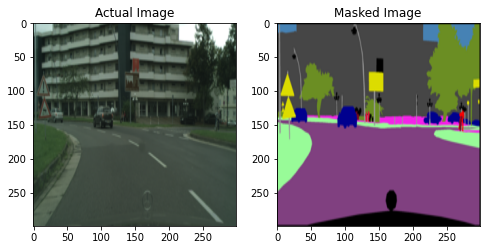

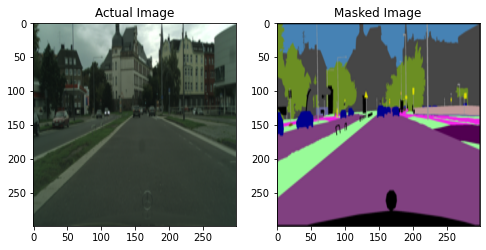

In [87]:
for img, gt in list(zip(im_train_ds.take(2), gt_train_ds.take(2))):
    visualize_images(img, gt, None)

In [ ]:
def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion operation to input X
    
    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X
    # block_a
    X = Conv2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
               padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = Conv2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
               padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = Conv2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
               padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Conv2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X
    
def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps 
    
    # block_1
    base = conv_block(input_layer,[32,32,64],'1')
    # # block_2
    base = conv_block(base,[64,64,128],'2')
    # # block_3
    base = conv_block(base,[128,128,256],'3')
    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module
    
    base = base_feature_maps(input_layer)
    # red
    red = GlobalAveragePooling2D(name='red_pool')(base)
    red = tf.keras.layers.Reshape((1,1,256))(red)
    red = Conv2D(filters=64,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=256,interpolation='bilinear',name='red_upsampling')(red)
    red = tf.image.resize(red, [IMG_SIZE, IMG_SIZE])
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Conv2D(filters=64,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    yellow = tf.image.resize(yellow, [IMG_SIZE, IMG_SIZE])
    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Conv2D(filters=64,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    blue = tf.image.resize(blue, [IMG_SIZE, IMG_SIZE])
    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Conv2D(filters=64,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    green = tf.image.resize(green, [IMG_SIZE, IMG_SIZE])
    # base + red + yellow + blue + green
    return tf.keras.layers.concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    X = Conv2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    X = Activation('sigmoid',name='last_conv_relu')(X)
    X = tf.keras.layers.Flatten(name='last_conv_flatten')(X)
    return X

In [ ]:
input_shape = list(im_train_ds.take(1))[0].shape
input_layer = tf.keras.Input(shape=input_shape, name='input')
output_layer = last_conv_module(input_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block_1_a (Conv2D)              (None, 299, 299, 32) 128         input[0][0]                      
__________________________________________________________________________________________________
block_1_batch_norm_a (BatchNorm (None, 299, 299, 32) 128         block_1_a[0][0]                  
__________________________________________________________________________________________________
block_1_leakyrelu_a (LeakyReLU) (None, 299, 299, 32) 0           block_1_batch_norm_a[0][0]       
_______________________________________________________________________________________

In [ ]:
# def get_images(gt_path, im_path):


In [ ]:
train_ds = tf.data.Dataset.zip((im_train_ds, gt_train_ds))
val_ds = tf.data.Dataset.zip((im_val_ds, gt_val_ds))

train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.fit(train_ds, validation_data=val_ds, epochs=10, steps_per_epoch=5, verbose=1, batch_size=32)

Epoch 1/10


ValueError: ignored